# Exercise 11) Policy Gradients

In this exercise we will have a look at policy gradients. 
The theory of policy gradients applies to function approximators that decide on which action to choose. 
The function approximators we met in the past were employed to estimate the (action) value function. 
Since their task was to judge the quality of the current situation they are often referred to as "critics". 
In contrary, we can also use a function approximator to directly choose an action; we call these "actors". 
Why should we do that if we made it work with nothing more than a critic? 
Because this will finally allow us to make use of contiuous action spaces! Eureka!

In this exercise we will use a new `gym` environment `LunarLanderContinuous-v2`.
To run this environment please make sure to have `Box2D` installed: `pip install Box2D`.

![](https://images.squarespace-cdn.com/content/v1/59e0d6f0197aea1a0abc8016/1507938542206-41S6K9T97YETKEHP0PQF/ke17ZwdGBToddI8pDm48kMR1yAHb8bPoH1-OdajP2rZZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpyDg3tXaPHS4cFkn9Bnm-emI0BDr_E-XKAFKqWrx68ZVlLyhCgVi_FJvVMH7mHrc18/lunar_lander_success_example.gif?format=500w)

Source: https://www.billyvreeland.com/portfolio/2017/1013/solving-openai-gym-nm4yz

The main task is to land the LunarLander in the landing zone.
An accident-free landing is defined by both legs coming into  ground contact with moderate velocity.
We are dealing with a continuous state and action space as defined below.
Please notice that the control functions for main and side engines contain a dead zone in which the engines are inactive.
The reward is mainly defined depending on whether the landing procedure is successful (+100) or not (-100).
Firing the main engine gives a small negative reward. 
The problem is solved if a return of at least 200 is reached. 
For more information see https://gymnasium.farama.org/environments/box2d/lunar_lander/.




\begin{align}
\text{state}&=
\begin{bmatrix}
p_x\\
p_y\\
v_x\\
v_y\\
\varphi\\
20 \, \omega\\
1 \text{ if left leg has ground contact, else } 0\\
1 \text{ if right leg has ground contact, else } 0\\
\end{bmatrix}
\\
\text{action}&=
\begin{bmatrix}
\text{main engine: } [-1, 0] \rightarrow \text{off}, ]0, 1] \rightarrow [50 \, \%, 100 \, \%] \text{ of available power}\\
\text{side engines: } [-1, -0.5] \rightarrow [50 \, \%, 100 \, \%] \text{ of available right engine power}, [0.5, 1] \rightarrow [50 \, \%, 100 \, \%] \text{ of available left engine power}\\
\end{bmatrix}
\end{align}

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
env = gym.make("LunarLander-v2",
                continuous=True,
              render_mode = "human")

state = env.reset()
while True:
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample())
    done = terminated or truncated

    if done:
        break
env.close()

## 1) Monte Carlo Policy Gradient
Write a REINFORCE algorithm.

Execute the following cell to fit the featurizer using RBFSampler, like already learned in the last exercises. 

In [3]:
env = gym.make("LunarLander-v2",
                continuous=True)
state_array = []
state = env.reset()

for i in tqdm(range(1000)):
    state, _ = env.reset()
    while True:
        state, reward, terminated, truncated, _ = env.step(env.action_space.sample())
        done = terminated or truncated
        state_array.append(state)

        if done:
            break

state_array = np.array(state_array)

featurizer = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 1000)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 1000)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 1000)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 1000)),
    ]),
    sklearn.preprocessing.StandardScaler()
)

_ = featurizer.fit(state_array)
env.close()


  0%|          | 0/1000 [00:00<?, ?it/s]

Use the following cell to define the function approximators for the policy.
As seen in Algo.12.1 we need to calculate $\nabla_\theta \mathrm{ln}\,\pi(u_k | x_k, \theta)$.
$\pi$ is herein defined as the normal distribution : 
\begin{align}
\pi(u_k | x_k, \theta) & = \frac{\mathrm{exp} \left( {-\frac{1}{2} (u_k - \mu_\theta(x_k))^\mathrm{T} \mathbf{\Sigma}^{-1}_\theta(x_k) (u_k - \mu_\theta(x_k))} \right)}{\sqrt{(2\pi)^p \mathrm{det}(\mathbf{\Sigma}_\theta(x_k))}},\\
\text{with}\hspace{1em} p & = \mathrm{dim}(u_k).
\end{align}

Extend `loglikelyhoodGaussian` such that it returns $\mathrm{ln}\,\pi(u_k | x_k, \theta)$! 
Use the numpy equivalent `PyTorch` functions (e.g. `torch.linalg.inv()`).
`PyTorch` functions are differentiable and can therefore be  used to calculate $\nabla_\theta \mathrm{ln}\,\pi(u_k | x_k, \theta)$.


In [4]:
class PolicyNetwork(nn.Module):

    def __init__(self, input_dim, action_space_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3_mu = nn.Linear(400, action_space_dim)
        self.fc3_sigma = nn.Linear(400, action_space_dim)

    def forward(self, x):
        """Predict the parameters of the stochastic distribution from which the action
        is sampled.
        """
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = F.leaky_relu(self.fc2(x), 0.1)

        mu_out = self.fc3_mu(x)
        mu_out = torch.clip(mu_out, -1, 1)[0]

        sigma_out = F.softplus(self.fc3_sigma(x))
        sigma_out = torch.mm(sigma_out, torch.tensor([[0.01, 0], [0, 0.1]]))
        sigma_out = torch.clip(sigma_out, 1e-4, 1)
        sigma_out = torch.diag_embed(sigma_out[0])

        return mu_out, sigma_out


def loglikelihood_gaussian(u, arg_mu, arg_sigma):
    """Evaluate the loglikelihood of the multivariate gaussian.
    
    Args:
        u: Where to evaluate the loglikelihood of the gaussian. In our case, this is
            the action whose likelihood we are evaluating.
        arg_mu: The mean vector of the gaussian distribution
        arg_sigma: The covariance matrix of the gaussian distribution
    """
    u = u.float()
    arg_mu = arg_mu.float()
    arg_sigma = arg_sigma.float()
    
    u_min_mu = u - arg_mu
    u_min_mu_col = u_min_mu.unsqueeze(1)
    
    quadratic_term = u_min_mu_col.t().mm(torch.inverse(arg_sigma)).mm(u_min_mu_col)
    log_det_sigma = torch.logdet(arg_sigma)
    
    dim = u.size(0)
    constant_term = dim * torch.log(torch.tensor(2.0 * np.pi))
    log_likelihood = -0.5 * (constant_term + log_det_sigma + quadratic_term)

    return log_likelihood.squeeze()  # Ensure it's a scalar

In [5]:
env = gym.make("LunarLander-v2", continuous=True)

state = np.reshape(env.reset()[0], (1, -1))
feature_state = featurizer.transform(state)
input_dim = feature_state.shape[1]
action_space_dim = len(env.action_space.sample())

policy = PolicyNetwork(input_dim, action_space_dim)

# Regularization; downscaling of the network parameters to prevent divergence
with torch.no_grad():
    for param in policy.parameters():
        param.mul_(0.4)

Use the following template to write a REINFORCE algorithm.
This time the Adam (adaptive moment estimation) optimizer is used, which is an enhanced SGD optimizer.
For more information on the optimizer, see https://arxiv.org/abs/1412.6980.

In [6]:
def interact(state, policy, deterministic, featurizer):
    """Interact with the environment to get to the next state.
    
    Args:
        state: The current state of the environment
        policy: The model that returns the mean and covariance matrix of the policy distribution
        deterministic: Whether to choose actions randomly or use the mean
        featurizer: The featurizer for state preprocessing

    Returns:
        next_state: The following state of the environment after the interaction
        reward: The reward for the interaction
        done: Whether the current episode is finished
        action: The chosen action
        mu: The mean vector of the policy distribution
        sigma: The covariance matrix of the policy distribution
    """
    feature_state = torch.tensor(featurizer.transform(state), dtype=torch.float32)
    mu, sigma = policy(feature_state)

    if deterministic:
        action = mu.detach().numpy().ravel()
    else:
        action = np.random.multivariate_normal(mean=mu.detach().numpy().ravel(), cov=sigma.detach().numpy())

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    return next_state, reward, done, action, mu, sigma


def gather_experience(policy, featurizer, max_episode_len=1000):
    """Simulates a full episode and returns the gathered data.

    Args:
        policy: The model that returns the mean and covariance matrix of the policy distribution
        featurizer: The featurizer for state preprocessing
        max_episode_len: The number of steps at which the episode is terminated automatically

    Returns:
        states: The states visited in the episode
        actions: The actions applied in the epsiode
        rewards: The rewards gathered in the episode
        probs_log: The loglikelihood values for the chosen actions
        accumulated_rewards: The sum of rewards over the episode
    """
    accumulated_rewards = 0

    states = []
    actions = []
    rewards = []
    probs_log = []

    state, _ = env.reset()
    state = torch.tensor(state.reshape(1, -1), dtype=torch.float32)

    for _ in range(max_episode_len):  # Limiting each episode to a maximum length
        next_state, reward, done, action, mu, sigma = interact(state, policy, False, featurizer)

        states.append(state)
        actions.append(torch.tensor(action, dtype=torch.float32))
        rewards.append(reward)
        probs_log.append(loglikelihood_gaussian(torch.tensor(action, dtype=torch.float32), mu, sigma))

        accumulated_rewards += reward
        state = torch.tensor(next_state.reshape(1, -1), dtype=torch.float32)

        if done:
            break
    
    return states, actions, rewards, probs_log, accumulated_rewards


def compute_returns(states, rewards, gamma):
    """Compute the returns based on the gathered rewards."""
    g_returns = []
    for t in range(len(states)):
        g_t = 0
        pw = 0
        for r in rewards[t:]:
            g_t = g_t + gamma**pw * r
            pw = pw + 1
        g_returns.append(g_t)
    return torch.tensor(g_returns, dtype=torch.float32)


def learn(states, rewards, gamma, probs_log, optimizer):
    """Learn from the gathered experience."""

    g_returns = compute_returns(states, rewards, gamma)

    # Calculate Policy Loss
    policy_loss = 0
    for log_prob, g_t in zip(probs_log, g_returns):
        policy_loss = policy_loss - log_prob * g_t

    # Update Policy
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    return policy_loss.item()


  0%|          | 0/5000 [00:00<?, ?it/s]

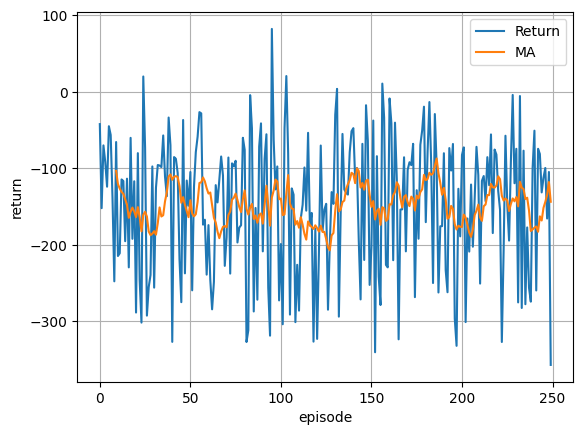

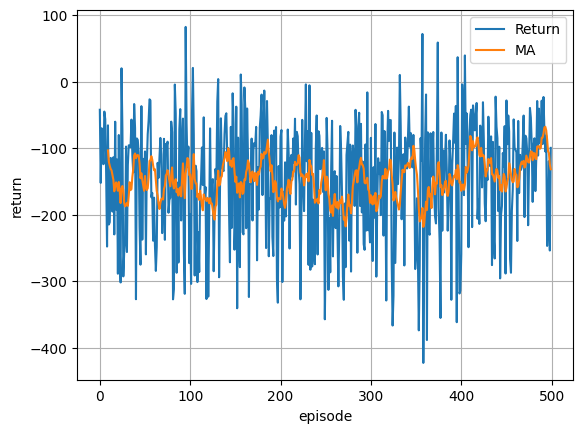

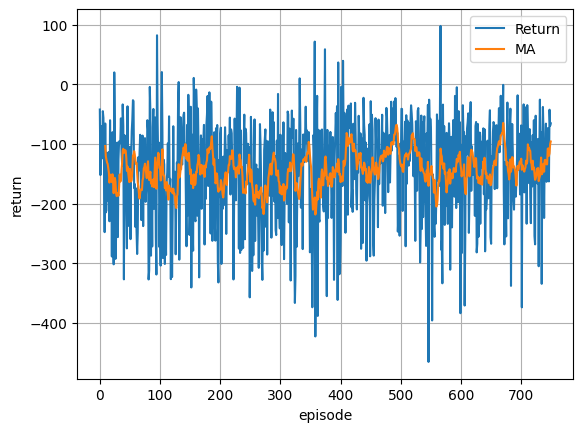

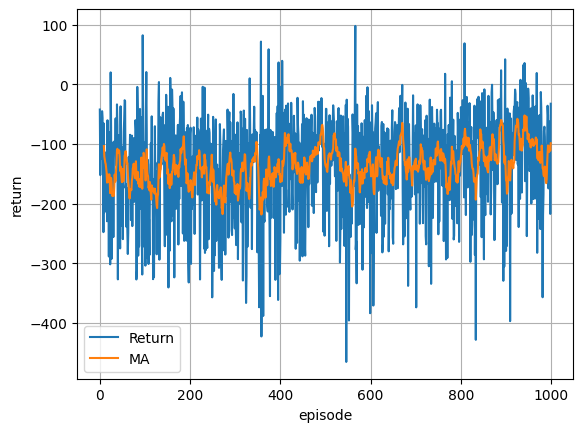

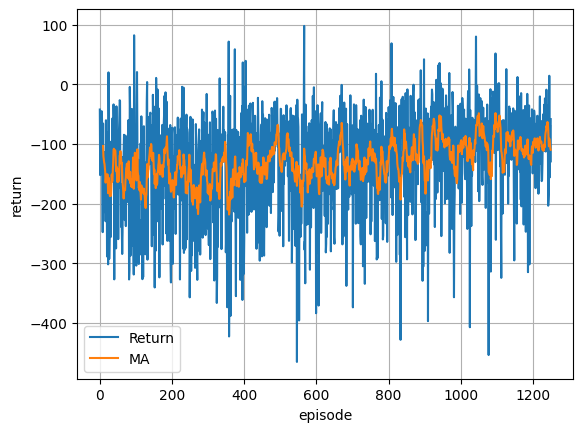

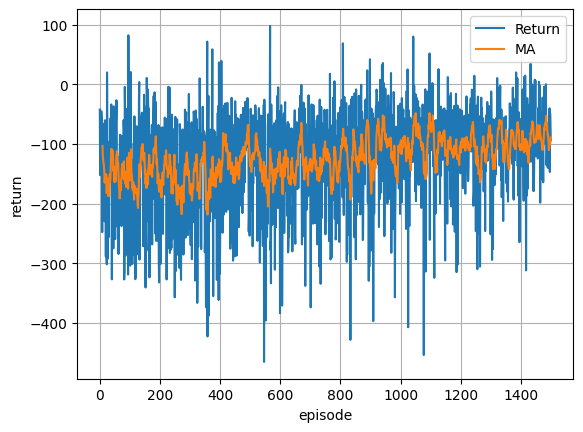

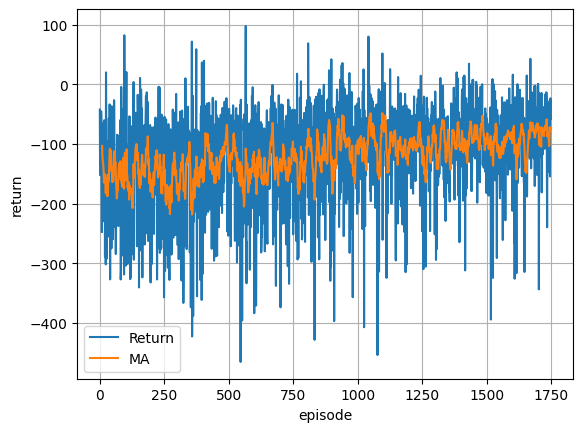

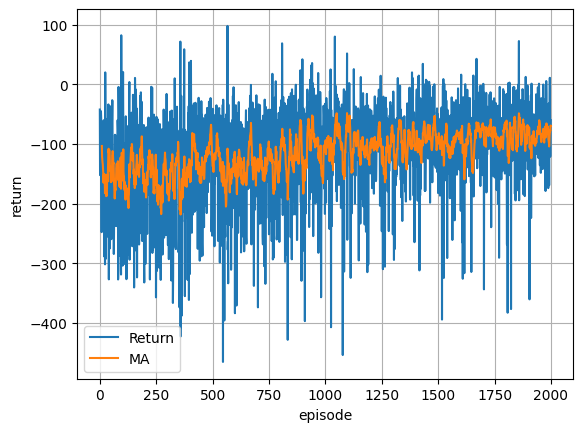

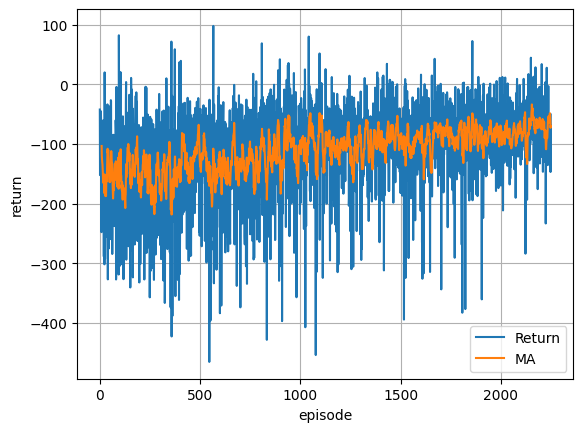

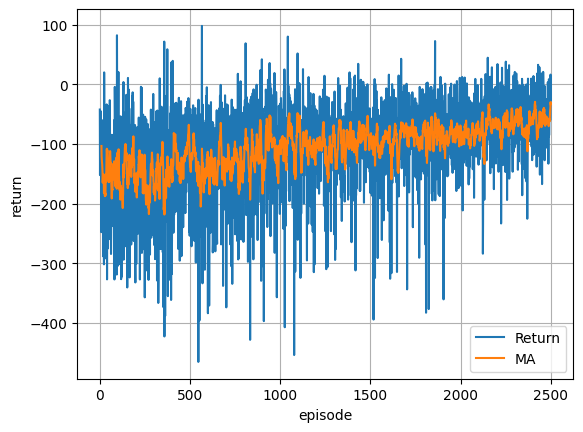

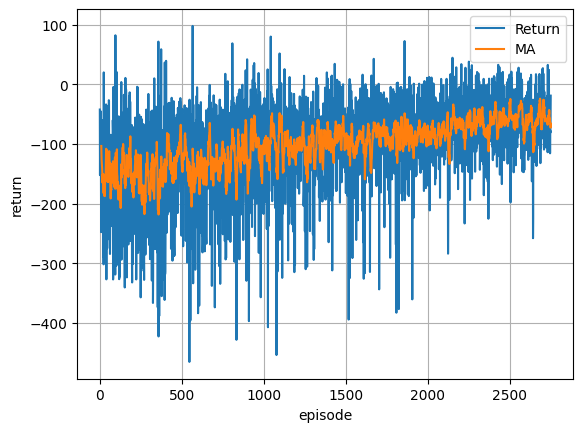

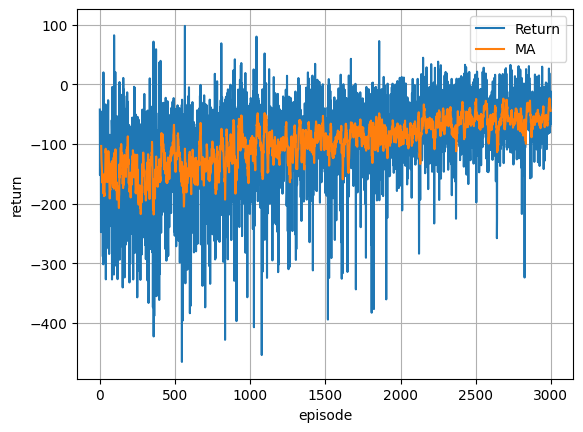

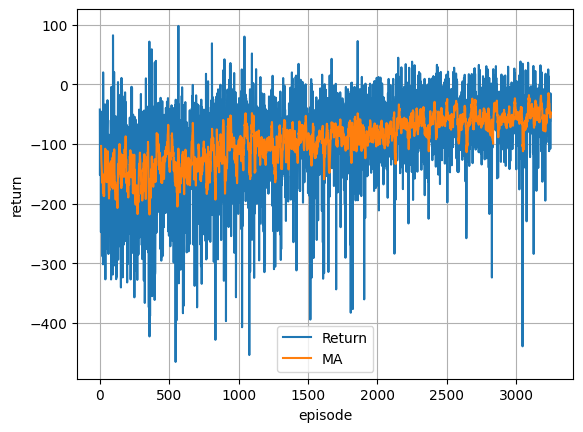

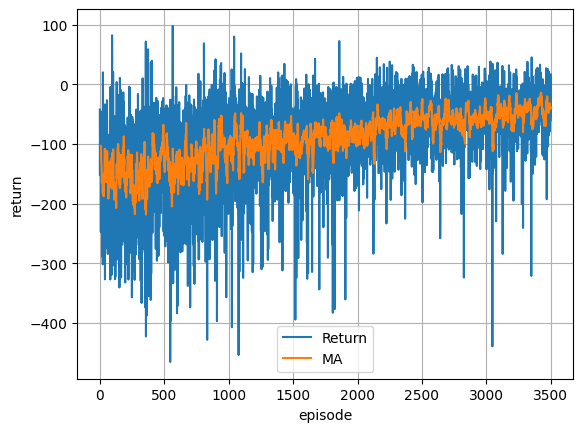

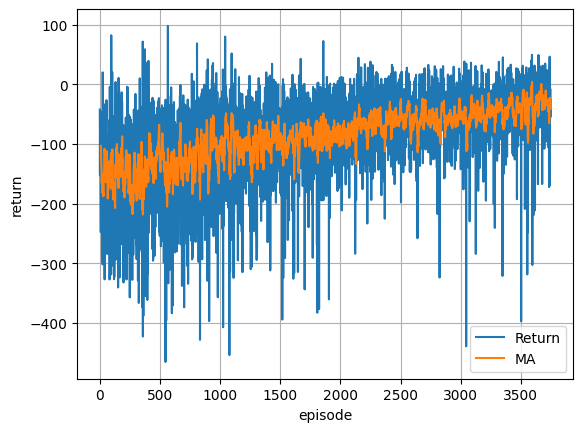

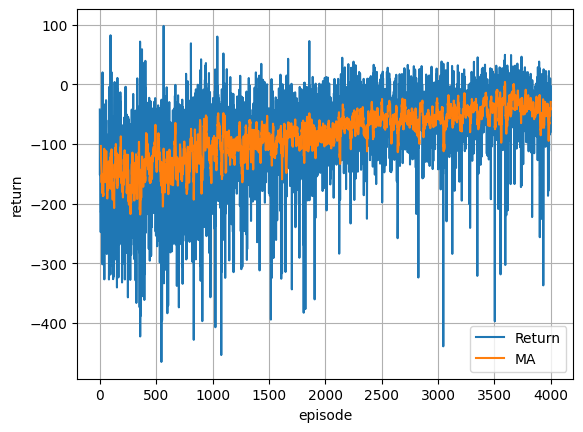

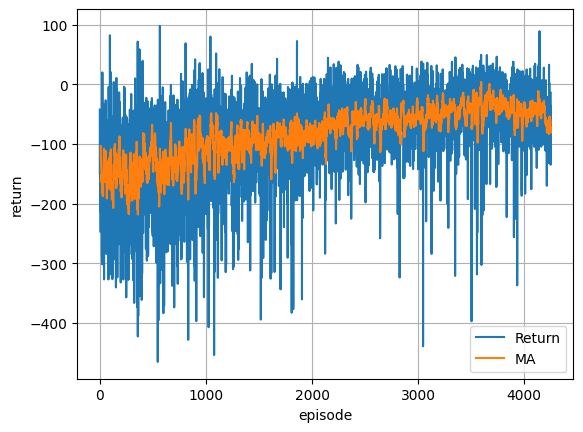

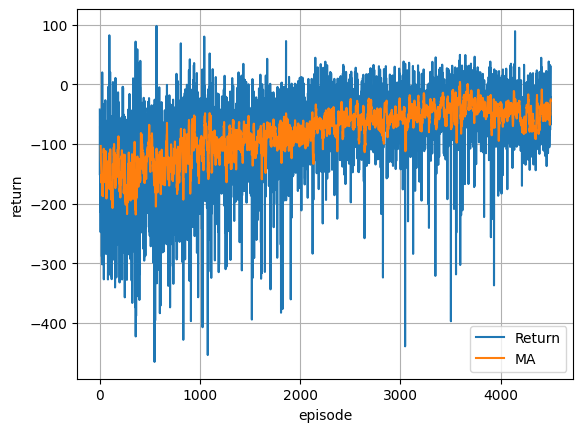

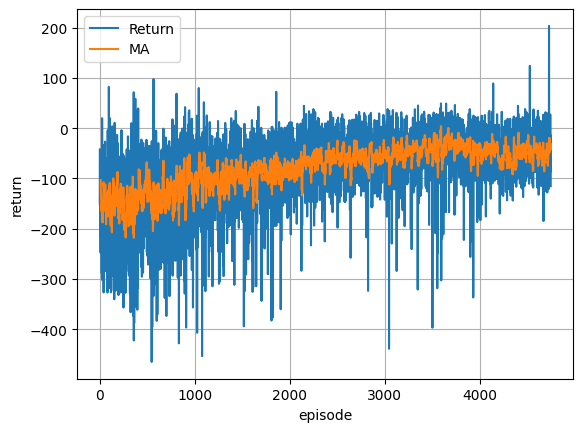

In [7]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
return_history = []

alpha_policy = 1e-5
optimizer = torch.optim.Adam(policy.parameters(), lr=alpha_policy)
gamma = 0.99
nb_episodes = 5000

for j in tqdm(range(nb_episodes)):

    states, actions, rewards, probs_log, accumulated_rewards = gather_experience(policy, featurizer)

    _ = learn(states, rewards, gamma, probs_log, optimizer)

    if j % 250 == 0 and j != 0:
        plt.plot(return_history, label='Return')
        plt.plot(pd.Series(return_history).rolling(10).mean(), label='MA')
        plt.xlabel('episode')
        plt.ylabel('return')
        plt.grid(True)
        _ = plt.legend()
        plt.show()
    return_history.append(accumulated_rewards)
    
env.close()

Plot the learning curve of the training process!

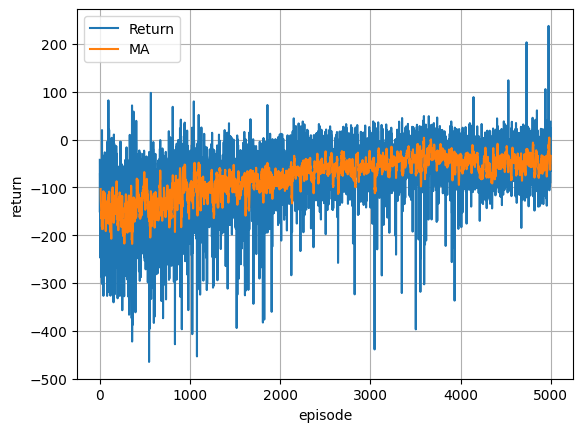

In [8]:
plt.plot(return_history, label='Return')
plt.plot(pd.Series(return_history, name='reward_history').rolling(10).mean(), label='MA')
plt.xlabel('episode')
plt.ylabel('return')
plt.grid(True)
_=plt.legend()

### Execution

Use `deterministic` to choose between deterministic execution (applying $\mu$ directly) or taking the stochastic action by sampling from the normal distribution.

In [9]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="human")

deterministic = False

for j in tqdm(range(10)):
    state, _ = env.reset()
    accumulated_rewards = 0

    while True:
        with torch.no_grad(): 
            next_state, reward, done, action, mu, sigma = interact(
                state = torch.tensor(state.reshape(1, -1), dtype=torch.float32),
                policy=policy,
                deterministic=False,
                featurizer=featurizer
            )

        accumulated_rewards += reward
        state = next_state

        if done:
            print(f"Episode {j}, Total Reward: {accumulated_rewards}")
            break

env.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 0, Total Reward: 20.74584902173997
Episode 1, Total Reward: -4.267739068206765
Episode 2, Total Reward: -72.81200517334707
Episode 3, Total Reward: -80.52821017391284
Episode 4, Total Reward: -55.36937847440839
Episode 5, Total Reward: -99.07418010900625
Episode 6, Total Reward: -74.43176477118128
Episode 7, Total Reward: 21.274465896806902
Episode 8, Total Reward: -4.120667224603494
Episode 9, Total Reward: 39.65121834590366


## 2) Actor-Critic with TD(0) Targets

Write an actor-critic (AC) algorithm to land the lander in the landing zone.


Use the following cell to create two function approximators. One to estimate the state values (critic) and one to decide on the actions to take (actor). 

In [10]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")

state = np.reshape(env.reset()[0], (1, -1))
input_dim = len(featurizer.transform(state)[0])
action_space_dim = len(env.action_space.sample())

class CriticNetwork(nn.Module):
    def __init__(self, input_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = self.fc3(x)
        return x

critic = CriticNetwork(input_dim)

for param in critic.parameters():
    param.data.mul_(0.2)
    
actor = PolicyNetwork(input_dim, action_space_dim)

for param in actor.parameters():
    param.data.mul_(0.4)

env.close()

Use the following template to write an AC algorithm.

In [11]:
def learn_critic(critic, critic_optimizer, state, next_state, done, gamma, featurizer):
    feat_state = torch.tensor(featurizer.transform(np.reshape(state, (1, -1))), dtype=torch.float32)
    next_feat_state = torch.tensor(featurizer.transform(np.reshape(next_state, (1, -1))), dtype=torch.float32)

    this_value = critic(feat_state)
    with torch.no_grad():
        next_value = critic(next_feat_state)
        delta = reward + (gamma * next_value * (1 - int(done))) - this_value

    critic_loss = - delta * this_value
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    return delta, critic_loss.item()


def learn_actor(actor_optimizer, action, mu, sigma, delta, I):

    actor_loss = - loglikelihood_gaussian(torch.tensor(action, dtype=torch.float32), mu, sigma) * I * delta

    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    return actor_loss.item()

  0%|          | 0/500 [00:00<?, ?it/s]

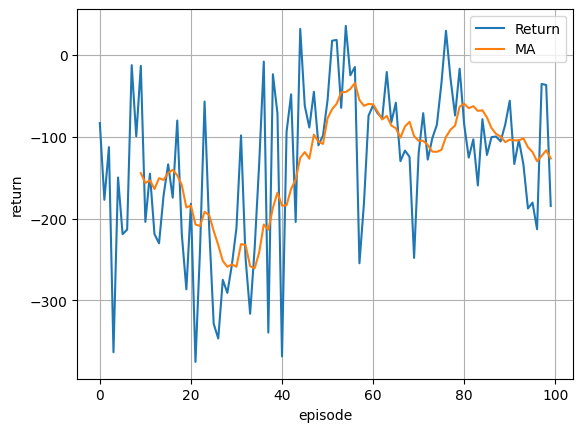

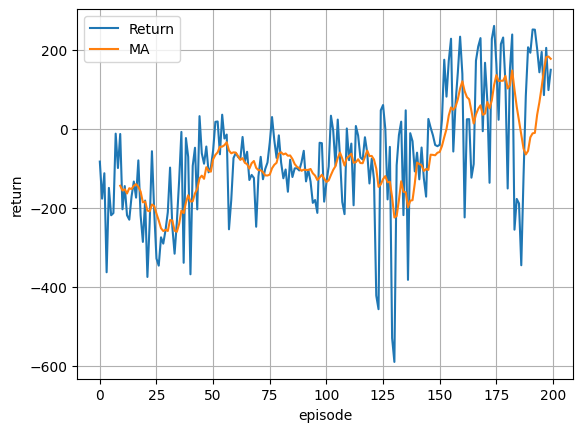

KeyboardInterrupt: 

In [12]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="rgb_array")
return_history = []

alpha_critic = 1e-4
alpha_actor = 1e-5
gamma = 0.99
nb_episodes = 500
max_episode_len = 1000

critic_optimizer = torch.optim.Adam(critic.parameters(), lr=alpha_critic)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=alpha_actor)

for j in tqdm(range(nb_episodes)):

    accumulated_rewards = 0
    state, _ = env.reset()
    I = 1

    for _ in range(max_episode_len):

        next_state, reward, done, action, mu, sigma = interact(
            state=np.reshape(state, (1, -1)),
            policy=actor,
            deterministic=False,
            featurizer=featurizer
        )
        accumulated_rewards += reward

        delta, _ = learn_critic(critic, critic_optimizer, state, next_state, done, gamma, featurizer)
        _ = learn_actor(actor_optimizer, action, mu, sigma, delta, I)

        I = gamma * I
        state = next_state

        if done:
            break

    if j % 100 == 0 and j != 0:
        plt.plot(return_history, label='Return')
        plt.plot(pd.Series(return_history).rolling(10).mean(), label='MA')
        plt.xlabel('episode')
        plt.ylabel('return')
        plt.grid(True)
        _ = plt.legend()
        plt.show()
    return_history.append(accumulated_rewards)

env.close()

Plot the learning curve of the training process!


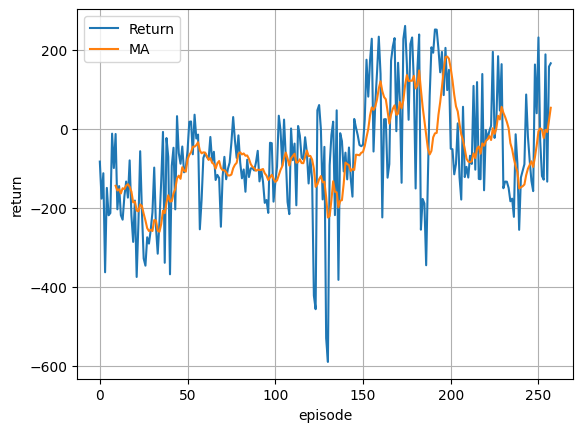

In [13]:
plt.plot(return_history, label='Return')
plt.plot(pd.Series(return_history, name='reward_history').rolling(10).mean(), label='MA')
plt.xlabel('episode')
plt.ylabel('return')
plt.grid(True)
_=plt.legend()

## Execution

Use `deterministic` to choose between deterministic execution (apply $\mu$) directly or take the stochastic action by sampling from the normal distribution.

In [14]:
env = gym.make("LunarLander-v2", continuous=True, render_mode="human")
deterministic = True

for j in tqdm(range(10)):
    state, _ = env.reset()
    accumulated_rewards = 0

    while True:

        with torch.no_grad():

            next_state, reward, done, action, mu, sigma = interact(
                state=np.reshape(next_state, (1, -1)),
                policy=actor,
                deterministic=True,
                featurizer=featurizer
            )

        accumulated_rewards += reward
        state = next_state

        if done:
            print(f"Episode {j}, Total Reward: {accumulated_rewards}")
            break

env.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 0, Total Reward: 183.28713112072177
Episode 1, Total Reward: -32.38685984080105
Episode 2, Total Reward: 222.414871799087
Episode 3, Total Reward: 144.78727905720055
Episode 4, Total Reward: 169.71422018219928
Episode 5, Total Reward: 130.52946941950367
Episode 6, Total Reward: -92.9129203590472
Episode 7, Total Reward: -25.17740195073793
Episode 8, Total Reward: -92.18460937398135
Episode 9, Total Reward: -41.98564609203667
